# Анализ результатов А/В-теста `recommender_system_test`

## Содержание
* [Цель исследования](#purpose)
* [Исходные данные](#data)
* [Предобработка данных](#preprocessing)
* [Исследовательский анализ данных](#analysis)
* [Воронка событий](#funnel)
* [Проверка гипотезы об отсутствии различий в конверсии между экспериментальной и контрольной группой](#hypothesis)
* [Выводы](#conclusions)

## Цель исследования <a id="purpose"></a>

Задача — провести оценку результатов A/B-теста в соответствии с техническим заданием, предварительно очистив данные.

Техническое задание:

* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_cart
    * покупки — purchase.

## Исходные данные <a id="data"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mth
import scipy.stats as st
!pip3 install -U seaborn==0.11.1
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import warnings 
warnings.filterwarnings('ignore')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from io import BytesIO
import requests


В нашем распоряжении 4 таблицы:
* `events` - основная таблица с данными о событиях, которые совершали участники теста;
* `participants` - данные по участникам теста (привязка к группе тестирования и названию теста). Не все пользователи участвовали в тесте, результаты которого нужно проверить;
* `new_users` - информация о том, когда пользователь зарегистрировался в системе;
* `marketing_events` - список маркетинговых акций (даты их проведения нужно учесть для исключения влияния на результаты теста)

In [2]:
spreadsheet_id = '1L7kwvX8xh8j_FrC5mVTTeiX8lgOC4XYLaLm9d58fp8o'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
events = pd.read_csv(BytesIO(r.content))
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 9:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 4:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [3]:
spreadsheet_id = '1q2gCqHoNXanbBHi5LYrZ1va0jrSqPtK-gEHCobyesyI'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
participants = pd.read_csv(BytesIO(r.content))
participants.info()
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [4]:
spreadsheet_id = '1iWPmkfHyuQkkrHwBGmrq-N4vyLhQUCH9oKCg7M5C74I'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
new_users = pd.read_csv(BytesIO(r.content))
new_users.info()
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [5]:
spreadsheet_id = '13-T-4QPxxDl4xhz4zmjU2JD47gzjRHuMmzuN4HLxAbw'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
marketing_events = pd.read_csv(BytesIO(r.content))
marketing_events.info()
marketing_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


## Предобработка данных <a id="preprocessing"></a>

Рассмотрим таблицы со вспомогательными данными на предмет ошибок.

Таблица `participants` не содержит пропусков. Проверим, в каких тестах участвовали люди из этого списка, и отфильтруем нужные результаты.

In [6]:
participants['ab_test'].unique()
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Проверим, есть ли такие пользователи, которые участвуют в двух тестах одновременно.

In [7]:
other_test_users = participants.query('ab_test == "interface_eu_test"')['user_id'].unique()
print('Количество пользователей, участвующих в двух тестах: ', participants.query('ab_test == "recommender_system_test" and user_id in @other_test_users')['user_id'].nunique())

Количество пользователей, участвующих в двух тестах:  1602


Таких пользователей много. Не будем убирать их из наших данных, но обратим внимание организаторов теста на этот факт.

Отфильтруем участников только нашего теста, затем проверим данные на дубликаты.

In [8]:
participants = participants.query('ab_test == "recommender_system_test"')
participants['ab_test'].value_counts()

recommender_system_test    6701
Name: ab_test, dtype: int64

In [9]:
participants.duplicated().sum()

0

Дубликатов, пропусков и лишних значений в файле `participants` нет. Его можно использовать для агрегации.

Расмотрим таблицу `new_users`. В ней должны остаться только пользователи, которые зарегистрировались в системе до 21.21.2020.

In [10]:
new_users = new_users.astype({'first_date': 'datetime64'})
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [11]:
print('Последний день регистрации в системе: {:%d-%m-%Y}.'.format(new_users['first_date'].max()))

Последний день регистрации в системе: 23-12-2020.


По условию ТЗ нужно отсечь пользователей, которые зарегистрировались в системе после 21.12.2020.

In [12]:
print('Количество пользователей в данных по регистрации:', new_users['user_id'].nunique())

Количество пользователей в данных по регистрации: 61733


In [13]:
new_users = new_users.query('first_date <= "2020-12-21"')
print('Количество пользователей, зарегистрировавшихся до 21.12.2020 включительно:', new_users['user_id'].nunique())

Количество пользователей, зарегистрировавшихся до 21.12.2020 включительно: 56470


In [14]:
print('Количество дубликатов в `new_users`:', new_users.duplicated().sum())

Количество дубликатов в `new_users`: 0


Построим сводную таблицу с разбивкой пользователей по регионам проживания.

In [15]:
region_pivot = new_users.pivot_table(index = 'region', values = 'user_id', aggfunc = pd.Series.nunique)
region_pivot

,user_id
region,
APAC,2883
CIS,2900
EU,42340
N.America,8347


Объединим таблицы с данными в одну для удобства работы. К таблице событий присоединяем таблицу участников. Отбираем только пользователей из второй таблицы (right join). Далее присоединяем информацию о новых пользователях.

In [16]:
data = events.merge(participants, on = 'user_id', how = 'right' ).merge(new_users, on = 'user_id', how = 'left' )
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27724 entries, 0 to 27723
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     27724 non-null  object        
 1   event_dt    24698 non-null  object        
 2   event_name  24698 non-null  object        
 3   details     3331 non-null   float64       
 4   group       27724 non-null  object        
 5   ab_test     27724 non-null  object        
 6   first_date  27724 non-null  datetime64[ns]
 7   region      27724 non-null  object        
 8   device      27724 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 2.1+ MB


Преобразуем дату в числовой формат.

In [17]:
data = data.astype({'event_dt': 'datetime64'})

In [18]:
print('Количество дубликатов в общей таблице:', data.duplicated().sum())

Количество дубликатов в общей таблице: 0


In [19]:
print('Проверка интервала проведения теста: {} - {}.'.format(data['event_dt'].min(), data['event_dt'].max())) 

Проверка интервала проведения теста: 2020-12-07 00:05:57 - 2020-12-30 12:42:57.


Посчитаем количество уникальных пользователей, попавших в тест.

In [20]:
print('Количество пользователей в тесте:', data['user_id'].nunique())

Количество пользователей в тесте: 6701


Посмотрим, какое количество новых пользователей из Европы попало в тест.

In [21]:
#Сводная таблица с агрегацией пользователей по регионам
region_pivot_test = data.pivot_table(index = 'region', values = 'user_id', aggfunc = pd.Series.nunique)
region_pivot_test

,user_id
region,
APAC,72
CIS,55
EU,6351
N.America,223


In [22]:
print('Доля новых пользователей из EU, попавших в тест: {:.0%}.'.format(region_pivot_test['user_id'][2]/region_pivot['user_id'][2]))

Доля новых пользователей из EU, попавших в тест: 15%.


Посмотрим, как представлены регионы в итоговой выборке пользователей.

In [23]:
data.pivot_table(index = ['group', 'region'], values = 'user_id', aggfunc = pd.Series.nunique)

user_id
group region            
A     APAC            37
      CIS             25
      EU            3634
      N.America      128
B     APAC            35
      CIS             30
      EU            2717
      N.America       95

Проверим, сколько пользователей из нашего теста совершало действия во время маркетинговых акций.

In [24]:
promo1 = ['N.America', 'EU']
promo2 = ['CIS']
print('Количество пользователей, совершавших действия в системе в период новогодних распродаж в Европе и Северной Америке:', data.query('region in @promo1').query('event_dt > "2020-12-25" and event_dt < "2021-01-03"')['user_id'].nunique())
print('Количество пользователей, совершавших действия в системе в период новогодних распродаж в странах СНГ:', data.query('region in @promo2').query('event_dt > "2020-12-30" and event_dt < "2021-01-07"')['user_id'].nunique())

Количество пользователей, совершавших действия в системе в период новогодних распродаж в Европе и Северной Америке: 1220
Количество пользователей, совершавших действия в системе в период новогодних распродаж в странах СНГ: 0


В столбцах времени и типа события есть пропуски. Посмотрим, сколько пользователей из теста не совершили никаких событий.

In [25]:
print('Количество пользователей, не совершивших никаких действий в период проведения теста:', data.query('event_dt.isna()', engine='python')['user_id'].nunique())

Количество пользователей, не совершивших никаких действий в период проведения теста: 3026


In [26]:
data.query('event_dt.isna()', engine='python').pivot_table(index = 'group', values = 'user_id', aggfunc = pd.Series.nunique)

,user_id
group,
A,1077
B,1949


Итак, в тест попали:
* все пользователи, зарегистрированные в системе до 21.12.2020 включительно;
* 15% от всех зарегистрированных пользователей из Европы;
* Европейцы составляют большую часть участников теста. На втором месте пользователи из Северной Америки. Жителей Азии и СНГ - меньшинство;
* количество участников теста - 6701 человек. Если убрать из теста тех, чьи действия попали на период распродажи, получится меньше 6000, необходимых для валидации теста. Придется их оставить, но иметь в виду погрешность, которую могут вызвать эти пересечения;
* Плановое время проведения теста: 7.12.2020 - 04.01.2021. Однако по имеющимся у нас данным тест был остановлен досрочно - 30.12.2020;
* Чуть меньше половины зарегистрированных пользователей не совершило после регистрации никаких значимых действий: около 1000 из группы А и почти 2000 из группы В.

## Исследовательский анализ данных <a id="analysis"></a>

Посмотрим, равномерно ли разбиты пользователи на группы в тесте.

In [27]:
ab_pivot = data.pivot_table(index = 'group', values = 'user_id', aggfunc = pd.Series.nunique)
ab_pivot['%_user'] = ab_pivot['user_id'] / (ab_pivot['user_id'].sum())
display(ab_pivot.style.format({'%_user':'{:.2%}'}))
print('Группа A больше группы B на {:.2%}.'.format((ab_pivot.query('group == "A"')['user_id'][0]/ab_pivot.query('group == "B"')['user_id'][0] - 1)))

,user_id,%_user
group,,
A,3824,57.07%
B,2877,42.93%


Группа A больше группы B на 32.92%.


Отклонение между размерами групп очень большое, это может исказить результаты теста. Но и сами выборки достаточно велики. Анализировать в любом случае будем конверсию относительно общего количества пользователей в каждой группе.

Проверим, не попали ли одни и те же пользователи в обе группы теста.

In [28]:
A = data.query('group == "A"')['user_id'].unique()
B = data.query('group == "B"')
AB = B.query('user_id in @A')['user_id'].nunique()
print('Количество пользователей, попавших в обе группы теста: ', AB)

Количество пользователей, попавших в обе группы теста:  0


Определим количество событий, рассматриваемых в таблице, и среднее количество событий, приходящихся на одного пользователя.

In [29]:
print('В логе {} типа событий.'.format(data['event_name'].nunique()))
print('В среднем один пользователь участвует в {:.0f} событиях.'.format(len(data) / data['user_id'].nunique()))

В логе 4 типа событий.
В среднем один пользователь участвует в 4 событиях.


Проверим, равномерно ли распределены события между пользователями.

count    6701.000000
mean        3.685719
std         4.376568
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max        28.000000
Name: event_name, dtype: float64

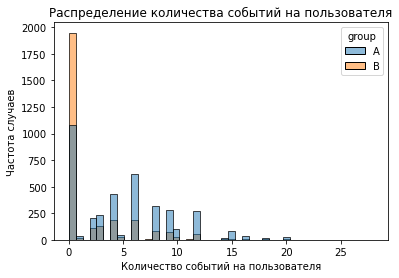

In [30]:
#Группируем события по каждому пользователю, выводим информацию по столбцу событий и строим распределение
event_per_id = data.groupby(['group', 'user_id']).agg({'event_name':'count'}).reset_index()
display(event_per_id['event_name'].describe())
sns.histplot(data = event_per_id, x = 'event_name', hue = 'group')
plt.title('Распределение количества событий на пользователя')
plt.xlabel('Количество событий на пользователя')
plt.ylabel('Частота случаев')
plt.show()

На гистограмме видно, что пользователи экспериментальной группы в среднем гораздо менее активны, чем контрольные. В группе В частота случаев, когда пользователь не совершил ни одного события, вдвое выше, чем в А.

Из-за большого количества пользователей, не совершивших никаких действий, распределение выглядит смещенным влево. Корректнее для описания среднего количества событий на пользователя использовать медиану - 2 события.

Выбросы удалять не будем. Посмотрим, как данные поведут себя при анализе.

Посмотрим на распределение количества событий в каждой группе во времени,чтобы подтвердить равномерность собранных данных.

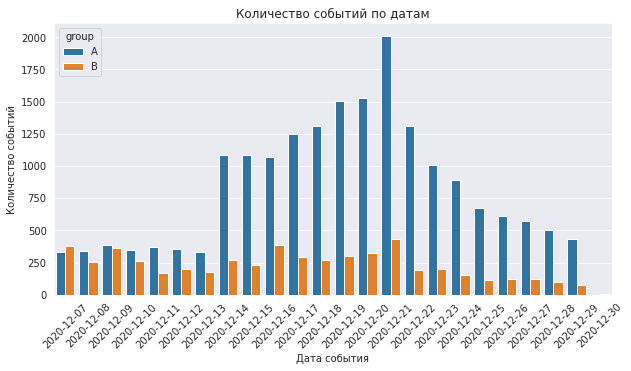

In [31]:
data['date'] = data['event_dt'].dt.date
event_date = data.pivot_table(index = ['date', 'group'], values = 'user_id', aggfunc = 'count').reset_index()
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
sns.barplot(data = event_date, x = 'date', y = 'user_id', hue = 'group')
plt.xticks(rotation = 45)
plt.title('Количество событий по датам')
plt.xlabel('Дата события')
plt.ylabel('Количество событий')
plt.show()

Явных аномалий в суточном количестве событий нет, но отчетливо видна тенденция роста активности за 12 дней до новогодней распродажи. Резкий всплеск в контрольной группе, плавный рост с двумя пиками в экспериментальной. Максимальная активность обеих групп пришлась на 20.12.2021.

Такая динамика активности по группам - первый сигнал, что эксперимент, возможно, пошел не так, как было запланировано. В начале периода группа В проявляла активность, сопоставимую с группой А (даже при том, что в В меньше пользователей), затем разрыв драматически вырос. Проверим эту гипотезу воронкой событий.

## Воронка событий <a id="funnel"></a>

По условию техзадания, метрики должны улучшиться не менее, чем на 10%, за 14 дней с момента регистрации пользователя в системе. 

Удалим из лога все события, которые превышают этот срок, но оставим пользователей, которые не совершали никаких действий - это наша база.


In [32]:
data['period'] = (data['event_dt'] - data['first_date']).astype('timedelta64[D]')
print('Количество событий до обработки:', len(data))

Количество событий до обработки: 27724


In [33]:
data = data.query('period <= 14 or period.isna()', engine = 'python')
print('Количество событий после обработки:', len(data))

Количество событий после обработки: 27096


In [34]:
print('Проверка. Период между датой регистрации и датой события для оставшихся пользователей: {:.0f} - {:.0f} дней.'.format(data['period'].min(), data['period'].max()))

Проверка. Период между датой регистрации и датой события для оставшихся пользователей: 0 - 14 дней.


In [35]:
data.sample(10)

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,date,period
10496,FCBE4B0CF081F04D,2020-12-22 19:07:27,product_page,NaN,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-22,2.0
4263,97AD409895906A32,2020-12-25 21:28:00,purchase,4.99,A,recommender_system_test,2020-12-21,EU,Android,2020-12-25,4.0
23146,2AD6903B2DCEAE0D,2020-12-20 08:12:47,product_page,NaN,A,recommender_system_test,2020-12-20,EU,Android,2020-12-20,0.0
10124,D072F407D6CE2C45,2020-12-17 07:01:57,product_cart,NaN,A,recommender_system_test,2020-12-17,EU,Android,2020-12-17,0.0
20720,DB79311DC523639B,2020-12-25 11:08:57,product_page,NaN,A,recommender_system_test,2020-12-15,EU,Android,2020-12-25,10.0
10192,F4190A5A95736012,2020-12-21 20:56:33,product_cart,NaN,A,recommender_system_test,2020-12-20,EU,Android,2020-12-21,1.0
26760,19E3408B4B4F85A9,2020-12-13 00:22:03,login,NaN,A,recommender_system_test,2020-12-10,N.America,Android,2020-12-13,3.0
19885,6E3DF9C69A6B607E,2020-12-14 08:29:56,product_cart,NaN,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-14,0.0
17953,053310D9D8FAB659,2020-12-15 21:44:40,product_cart,NaN,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15,1.0
17722,0E24E4F981343864,2020-12-16 15:07:56,login,NaN,B,recommender_system_test,2020-12-07,EU,Android,2020-12-16,9.0


Такая разбивка по пользователям осталась в соответствии с ТЗ.

In [36]:
data.groupby('group')['user_id'].nunique() 

group
A    3824
B    2877
Name: user_id, dtype: int64

Посмотрим, в каком порядке идут события, и построим воронку отдельно по каждой группе.

In [37]:
a_data = data.query('group == "A"')
b_data = data.query('group == "B"')

In [38]:
data_funnel_A = a_data.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'count').reset_index().sort_values(by = 'user_id', ascending = False)
data_funnel_B = b_data.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'count').reset_index().sort_values(by = 'user_id', ascending = False)
print('Данные для частотной воронки продаж по группе А')
display(data_funnel_A)
print('Данные для частотной воронки продаж по группе В')
data_funnel_B

Данные для частотной воронки продаж по группе А


,event_name,user_id
0,login,8400
2,product_page,5415
3,purchase,2613
1,product_cart,2519


Данные для частотной воронки продаж по группе В


,event_name,user_id
0,login,2493
2,product_page,1331
1,product_cart,659
3,purchase,640


По убыванию частоты событий идут этапы:
* Вход в приложение (на сайт)
* Просмотр страницы продукта
* Заказ
* Переход в корзину

Заказ - последнее логическое звено в цепочке событий. Получается, что некоторые пользователи могут не проходить по классической цепочке, а напрямую заказывать нужный продукт (видимо, заказ "в один клик" прямо со страницы продукта). В связи с этим корректно будет оценивать конверсию каждого этапа из техзадания по отношению к первому событию.


Визуализируем воронку по частоте событий, отсортировав этапы по порядку:



In [39]:
#Расположим события в правильном порядке вручную
data_funnel_A = data_funnel_A.reindex([0,2,1,3])
data_funnel_B = data_funnel_B.reindex([0,2,1,3])
#Воронку делаем по каждой группе теста отдельно
fig = go.Figure(layout_title_text='Частотная воронка событий')
fig.add_trace(go.Funnel(y=data_funnel_A['event_name'], x = data_funnel_A['user_id'], marker = {"color": "#1c1847"}, name='A',
    textinfo = 'value+percent previous+percent initial'))
fig.add_trace(go.Funnel(y=data_funnel_B['event_name'], x = data_funnel_B['user_id'], marker = {"color": "red"}, name = 'B', 
    textinfo = 'value+percent previous+percent initial'))
fig.show()

Наихудшая конверсия в частотной воронке - на этапе перехода от просмотра страницы продукта к корзине. 50% в экспериментальной группе и 47% в контрольной.

Доля финального события - покупки - составляет 26% от общего числа событий в экспериментальной группе и 31% - в контрольной.

Построим еще одну воронку - по количеству пользователей, которые проходили эти этапы. 

К этапам в таблице добавим строку с общим количеством зарегистрированных пользователей, чтобы узнать конверсию регистрация/логин.

In [40]:
'''Напишем функцию, которая будет строить сводную таблицу для воронки продаж по уникальным пользователям'''
def funnel_by_users(data):
  #Сводная таблица количества пользователей группы А по каждому этапу
  data_funnel_2 = data.pivot_table(index = 'event_name', values = 'user_id', aggfunc = pd.Series.nunique).reset_index()
  #Добавляем событие - регистрация, чтобы видеть в воронке общее количество пользователей
  data_funnel_2 = data_funnel_2.append({'event_name': 'Registration', 'user_id':  data['user_id'].nunique()}, ignore_index=True).sort_values(by = 'user_id', ascending = False)
  #Конверсия по отношению к общему количеству пользователей приложения/сайта
  data_funnel_2['%_users'] = data_funnel_2['user_id']/data['user_id'].nunique()
  data_funnel_2 = data_funnel_2.reindex([4,0,2,1,3])
  print('Данные для воронки продаж по пользователям  группы ', data['group'].unique())
  return (data_funnel_2)
a = funnel_by_users(a_data)
display(a.style.format({'%_users':'{:.2%}'}))
b = funnel_by_users(b_data)
b.style.format({'%_users':'{:.2%}'})

Данные для воронки продаж по пользователям  группы  ['A']


,event_name,user_id,%_users
4,Registration,3824,100.00%
0,login,2747,71.84%
2,product_page,1780,46.55%
1,product_cart,824,21.55%
3,purchase,872,22.80%


Данные для воронки продаж по пользователям  группы  ['B']


,event_name,user_id,%_users
4,Registration,2877,100.00%
0,login,927,32.22%
2,product_page,523,18.18%
1,product_cart,255,8.86%
3,purchase,256,8.90%


In [41]:
fig = go.Figure(layout_title_text='Воронка событий по количеству пользователей')
fig.add_trace(go.Funnel(y=a['event_name'], x = a['user_id'],
    textinfo = 'value+percent previous+percent initial', marker = {"color": "#1c1847"}, name='A'))
fig.add_trace(go.Funnel(y=b['event_name'], x = b['user_id'],
    textinfo = 'value+percent previous+percent initial', marker = {"color": "red"}, name = 'B'))
fig.show()

68% пользователей экспериментальной группы не пошло дальше регистрации. Действий в системе они не совершали.

Из тех, кто залогинился, на следующий этап (просмотр карточки продукта)  перешли 65% пользователей контрольной группы и всего 56% - из экспериментальной.

В экспериментальной группе лучше относительные показатели конверсии перехода в корзину со страницы продукта, но итоговая конверсия в заказ - всего 28% против 32% в контрольной группе.

Отдельно отметим, что в экспериментальной группе только один человек сделал покупку "мимо корзины". В контрольной таких покупателей 48.

Похоже, что показатели экспериментальной группы не лучше контрольной.

Посмотрим, как выглядит средний чек в обеих группах.

In [42]:
print('Средний чек покупателя из контрольной группы: {:.2f} у.е.'.format(a_data['details'].sum()/a_data['user_id'].nunique()))
print('Средний чек покупателя из контрольной группы: {:.2f} у.е.'.format(b_data['details'].sum()/b_data['user_id'].nunique()))

Средний чек покупателя из контрольной группы: 15.87 у.е.
Средний чек покупателя из контрольной группы: 5.16 у.е.


По среднему чеку в экспериментальной группе тоже провал. В первую очередь из-за того, что большая часть пользователей, зарегистрировавшихся в системе, остались неактивными.

Представим конверсию в виде таблицы, удобной для анализа.

In [43]:
'''Функция расчета конверсии количества пользователей по событиям. На вход подается файл с событиями, 
на выходе таблица конверсии по этапам и по отношению к первому этапу'''  
def conv_func(data):
  #Группируем события по кол-ву уникальных пользователей
  data_events = data.groupby('event_name').agg({'user_id':'nunique'}).reset_index().sort_values(by = 'user_id', ascending = False)
  #Создаем колонку, где строке из столбца с пользователями будет соответствовать значение предыдущей строки этого же столбца. Он нужен для расчета конверсии
  data_events = data_events.reindex([0,2,1,3])
  data_events['prev_id'] = data_events['user_id'].shift(1).fillna(data['user_id'].nunique()).astype('int')
  #Расчетный столбец конверсии между этапами
  data_events['conversion'] = data_events['user_id'] / data_events['prev_id']
  #Расчетный столбец конверсии по отношению к первому этапу
  data_events['conversion_initial'] = (data_events['user_id'] / data_events.query('event_name == "login"')['prev_id'].sum())
  #data_events.insert(3, 'initial', data_events.query('event_name == "login"')['user_id'].sum())
  return data_events
print('Таблица конверсии для группы', a_data['group'].unique())
display(conv_func(a_data).style.format({'conversion':'{:.2%}', 'conversion_initial':'{:.2%}'}))
print('Таблица конверсии для группы', b_data['group'].unique())
conv_func(b_data).style.format({'conversion':'{:.2%}', 'conversion_initial':'{:.2%}'})

Таблица конверсии для группы ['A']


,event_name,user_id,prev_id,conversion,conversion_initial
0,login,2747,3824,71.84%,71.84%
2,product_page,1780,2747,64.80%,46.55%
1,product_cart,824,1780,46.29%,21.55%
3,purchase,872,824,105.83%,22.80%


Таблица конверсии для группы ['B']


,event_name,user_id,prev_id,conversion,conversion_initial
0,login,927,2877,32.22%,32.22%
2,product_page,523,927,56.42%,18.18%
1,product_cart,255,523,48.76%,8.86%
3,purchase,256,255,100.39%,8.90%


По ТЗ ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
* конверсии в просмотр карточек товаров — событие product_page
* просмотры корзины — product_cart
* покупки — purchase.

К сожалению, данные не показывают такой динамики на экспериментальной группе.

## Проверка гипотезы об отсутствии различий в конверсии между экспериментальной и контрольной группой <a id="hypothesis"></a>

Проверим, есть ли статистические различия в конверсии между двумя группами теста.

Нулевая гипотеза - статистически значимых различий между группами нет.

H1 - различия статистически значимы.

Для проверки гипотезы используем z-test.

In [44]:
#Пишем функцию проверки статзначимости по z-тесту
def z_test(n1, x1, n2, x2):
  #Конверсии по группам:
  p1 = x1 / n1
  p2 = x2 / n2
  #Общая конверсия
  p = (x1 + x2) / (n1 + n2)
  #Разница между конверсиями
  difference = p1 - p2
  #Расчет z-значения (статистики разницы между конверсиями)
  z_value = difference / (p * (1 - p) * (1/n1 + 1/n2))**0.5
  #Статистика распределена нормально, используем при расчете p_value (среднее 0, ст.отклонение 1)
  distr = st.norm(0, 1)
  #Задаем функцию нормального распределения для расчета критерия 
  p_value = (1 - distr.cdf(abs(z_value))) * 2
  return p_value

In [45]:
#Объединяем данные конверсии по двум группам в одну таблицу
AB = conv_func(a_data).merge(conv_func(b_data), on = 'event_name')
#Для удобства переименуем столбцы
AB.columns = ['event_name', 'A', 'prev_step_A', 'conv_A', 'conv_initial_A', 'B', 'prev_step_B', 'conv_B', 'conv_initial_B']

In [46]:
AB.iloc[0,5]

927

In [47]:
#Добавляем столбец с уровнем значимости
AB['alpha'] = 0.05
#В этом столбце считаем относительную конверсию 
AB['p_value_relative'] = AB.apply(lambda x: z_test(x['prev_step_A'], x['A'], x['prev_step_B'], x['B']), axis = 1)  
#В этом столбце считаем абсолютную конверсию 
AB['p_value_initial'] = AB.apply(lambda x: z_test(AB.iloc[0,2], x['A'], AB.iloc[0,6], x['B']), axis = 1)
  
AB.style.format({'p_value_relative':'{:.5f}', 'p_value_initial':'{:.5f}'})
AB

,event_name,A,prev_step_A,conv_A,conv_initial_A,B,prev_step_B,conv_B,conv_initial_B,alpha,p_value_relative,p_value_initial
0,login,2747,3824,0.718358,0.718358,927,2877,0.322211,0.322211,0.05,0.000000,0.0
1,product_page,1780,2747,0.647980,0.465481,523,927,0.564186,0.181787,0.05,0.000005,0.0
2,product_cart,824,1780,0.462921,0.215481,255,523,0.487572,0.088634,0.05,0.320620,0.0
3,purchase,872,824,1.058252,0.228033,256,255,1.003922,0.088982,0.05,0.000502,0.0


Единственный этап, где нельзя отвергнуть гипотезу об отсутствии различий между группами - конверсия перехода в корзину относительно предыдущего этапа. Но у нас слишком разные по количеству группы, чтобы принимать относительную конверсию за основной показатель. В данном случае следует ориентироваться на различия в абсолютной конверсии. 

Z-test показал, что на всех этапах различия между абсолютными конверсиями статистически значимы (p_value_initial < alpha). Таким образом, **отвергаем гипотезу о том, что статистически значимых различий в группах А и В нет**, и принимаем альтернативную.

## Выводы <a id="conclusions"></a>

Мы проанализировали качество и результаты проведенного А/В-теста.
При анализе качества проведения теста выявлены особенности, которые могли повлиять на результаты:
* На период проведения теста приходятся новогодние акции, и 1220 пользователей совершали действия в системе в это время;
* 1602 пользователя участвуют одновременно в двух тестах;
* Контрольная и экспериментальная группы разбиты неравномерно, разница между их размерами - 33%;
* Тест был остановлен досрочно: 30.12.2020 вместо 4.01.2021.


Результаты теста:
* При анализе последовательности событий выявилось, что 48 пользователей из контрольной группы и 1 из экспериментальной совершили заказ, минуя корзину (заказ в один клик со страницы продукта?). Верную последовательность устанавливали вручную;
* Треть пользователей контрольной группы и две трети из экспериментальной не совершали никаких действий после регистрации на сервисе. Из-за этого **абсолютные показатели экспериментальной группы хуже, чем аналогичные у контрольной**. Это подтверждено статистическим тестом;
* Средний чек у контрольной группы выше, чем у экспериментальной, в 3 раза;
* Абсолютная конверсия в заказы в контрольной группе составила 23% против 9% в экспериментальной.

Тест показал, что **внедрение улучшенной рекомендательной системы не привело к росту конверсии ни на одном из отмеченных в ТЗ этапов**. Целевые показатели (прирост 10% в конверсии просмотра карточек товаров, корзины и совершения покупки за 14 дней с момента регистрации пользователя в системе) не достигнуты.

Самый **главный вопрос**, требующий дополнительного анализа - **почему большая часть пользователей экспериментального теста не стала пользоваться сервисом после регистрации**.

Кроме указанных проблем, возможно, слишком жёстко задан временной период для сравнения показателей.